In [183]:
import os
import sys
import shutil
import random
import re
import gzip
import csv
import subprocess
import json

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import sumolib
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import traci
import traci.constants as tc
import carla

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import vehParameters
import osmAPI as osm
import LLAMAconnect

FOLDER_NAME = "town05"

### Defining paths and setting up osm.sumocfg file

In [68]:
def add_xml_child(file_path, parent_tag, child_tag, child_value, replace=True):
    """
    Adds a new child parameter inside a specified parent tag in the XML configuration file.
    If the parent tag does not exist, it creates a new parent tag (<parameter>) with the child.
    It also checks if the child element already exists to prevent duplicates.

    Args:
        file_path (str): Path to the XML configuration file.
        parent_tag (str): The parent tag under which to add the child (e.g., 'input').
        child_tag (str): The child tag to add (e.g., 'additional-files').
        child_value (str): The value to set for the new child tag.
        replace (bool): If True, replaces the existing child tag with the new value.
                        If False, adds another child value.
    Returns:
        bool: True if the addition was successful, False otherwise.
    """
    try:
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find the parent element by tag
        parent_elem = root.find(parent_tag)
        if parent_elem is None:
            print(f"Parent tag '{parent_tag}' not found. Creating new parent tag.")
            parent_elem = ET.Element(parent_tag)
            root.append(parent_elem)
            print(f"Created new parent tag <{parent_tag}>.")

        # Check if the child element already exists inside the parent element
        existing_child = parent_elem.find(child_tag)
        if existing_child is not None: 
            
            if existing_child.get('value') == child_value:
                print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                return False
            else:
                if replace:
                    print(f"Child <{child_tag}> already exists. Updating value to '{child_value}'.")
                    existing_child.set('value', child_value)
                else:
                    if child_value in existing_child.get('value').split(', '):
                        print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                        return False
                    
                    print(f"Child <{child_tag}> already exists. Adding another child with value '{child_value}'.")
                    existing_child.set('value', f'{existing_child.get("value")}, {child_value}')
                
                tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
                print("XML file updated successfully.")
                return True

        # Create the new child element and set its value
        new_child = ET.Element(child_tag)
        new_child.set('value', child_value)
        print(f"Created <{child_tag}> with value '{child_value}'.")

        # Add the new child to the parent element
        parent_elem.append(new_child)
        print(f"Added <{child_tag}> to <{parent_tag}>.")

        # Write the updated XML to the file
        tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
        print("XML file updated successfully.")
        return True

    except ET.ParseError as e:
        print(f"XML Parsing error: {e}")
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [145]:
NET_PATH = f'{FOLDER_NAME}/osm.net.xml'
PA_PATH = f'{FOLDER_NAME}/park.add.xml'
SUMOCFG_PATH = f'{FOLDER_NAME}/osm.sumocfg'
PA_REROUTER_PATH = f'{FOLDER_NAME}/pa_rerouter.xml'

# Setting up time to teleport as 
# -1 (never teleport): Vehicles will never teleport, but this could cause deadlock.
# >0 (seconds): Vehicles will teleport after the specified time if they are not able to reach their destination.
time_to_teleport = 100
add_xml_child(SUMOCFG_PATH, 'processing', 'time-to-teleport', f'{time_to_teleport}')

# Adding lateral resolution to use SubLane model
lateral_resolution = 0.8
add_xml_child(SUMOCFG_PATH, 'parameters', 'lateral-resolution', f'{lateral_resolution}')

# Setting up the timestep (default is 1 second), this does not affect the simulation speed but the resolution of the simulation. A smaller timestep will result in a more accurate simulation
step_length = 0.1
add_xml_child(SUMOCFG_PATH, 'time', 'step-length', f'{step_length}')

# Setting up the simulation duration. To simulate 24 hours, we set the end time to (3600 steps * 24 hours) / step_lenght.
end_time = ''
add_xml_child(SUMOCFG_PATH, 'time', 'end', f'{end_time}')

if not os.path.exists(NET_PATH):
    gz_path = f"{FOLDER_NAME}/osm.net.xml.gz"
    if os.path.exists(gz_path):
        with gzip.open(gz_path, 'rb') as f_in:
            with open(NET_PATH, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Extracted {gz_path} to {NET_PATH}")
    else:
        raise FileNotFoundError(f"{gz_path} does not exist.")
    
net = sumolib.net.readNet(NET_PATH)

if not os.path.exists(PA_PATH):
    print(f"{PA_PATH} does not exist. No using any parking areas.")
else:
    parkingAreas = list(sumolib.output.parse(PA_PATH, "parkingArea"))
    # Setting up additional files
    add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', "park.add.xml, pa_rerouter.xml")

net_offset = net.getLocationOffset() # Necessary to convert from CARLA to SUMO coordinates if needed

Child <time-to-teleport> with value '100' already exists. Skipping addition.
Child <lateral-resolution> with value '0.8' already exists. Skipping addition.
Child <step-length> with value '0.1' already exists. Skipping addition.
Child <end> already exists. Updating value to ''.
XML file updated successfully.
Child <additional-files> already exists. Updating value to 'park.add.xml, pa_rerouter.xml'.
XML file updated successfully.


In [70]:
def flush_print():
    sys.stdout.write("\r")  # Move the cursor to the beginning of the line
    sys.stdout.write(" " * 50)  # Overwrite with spaces to clear the line
    sys.stdout.write("\r")  # Move back to the beginning again

In [71]:
def has_parking_spot(lanes, parkingAreas):
    # Example of parkingArea:
    # <parkingArea id="pa-1046248579#0" lane="-1046248579#0_0" roadsideCapacity="94" length="5.00"/>
    # Returns parkingArea id if there is a parking spot in the lane
    lane_ids = [lane.getID() for lane in lanes]
    for park in parkingAreas:
        if park.lane in lane_ids:
            return park.id
    return False

In [72]:
def getClosestEdges(lat, lon, radius, maxEdges=10, convert_toXY=True):

    # Gets the 10 closest edges to the given lat, lon
    if convert_toXY:
        x, y = net.convertLonLat2XY(lon, lat)
    else:
        x, y = lon, lat
    edges = net.getNeighboringEdges(x, y, radius)
    closestEdges = []
    if (len(edges) > 0):
        distanceAndEdges = sorted([(dist, edge) for edge, dist in edges], key=lambda x:x[0])

        ## Checking if the edge found can be used by passenger car
        for dist, edge in distanceAndEdges:
            if edge.allows('passenger'):
                closestEdges.append(edge)

    if len(edges) == 0:
        print(f'No edges found for {lat}, {lon}. Perhaps location is not inside the network or there are no viable roads inside the radius.')
        return None
    
    return closestEdges

In [73]:
def getParkingSpot(lat, lon, radius, parkingAreas):
    # Get the parking spot closest to the given lat, lon
    # Used to set stops for the vehicles

    edges = getClosestEdges(lat, lon, radius)
    # Look for parking spots
    for i in range(len(edges)):
        parking_spot = has_parking_spot(edges[i].getLanes(), parkingAreas)
        if parking_spot:
            return parking_spot
    print(f"No parking spot found close to {lat}, {lon}. Perhaps decrease the radius?")
    return None

In [74]:
def getPath(location_time_list, parkingAreas, steps_per_stop, radius = 100, use_carla_routine=False):
    # All that is needed to create the trip are the stops (parking areas) and the start and end edges.
    # The duarouter is responsible for finding the path between the edges going through the stops.
    # Here, we get the edges and stops that are going to be sent to LLAMA to create the trip.

    # 'coordinates' is a list of tuples with the latitude and longitude of the points of interest, for example IC, FEEC, IC means that
    # the vehicle will start from IC, stop at a parking lot close to FEEC, and then back to IC.
    # The first and last coordinates should be edges and the others should be parking spots.
    # `steps_per_stop` is the number of simulation steps that the vehicle will stay at each stop.

    # Departure for 7 is 0, 8 is 100, 9 is 200 and so on
    stop_durations = []
    departures = list(location_time_list.keys())
    stop_durations.append(-1) # Indicates this is an edge and not a parking spot

    path = []
    coords = [location_time_list[k]['coords'] for k in location_time_list.keys()]
    
    if use_carla_routine: 
        convert_toXY = False # No need to convert from lat, lon to XY
        
    home = getClosestEdges(*coords[0], radius, convert_toXY=convert_toXY)[0].getID()
    path.append(home)
        
    for i in range(1, len(coords)-1):

        stop_durations.append(steps_per_stop * (departures[i + 1] - departures[i]))
        if use_carla_routine: # When using the carla routine, we don't have parking spots
            ps = getClosestEdges(*coords[i], radius, convert_toXY=convert_toXY)[0].getID()
        else:
            ps = getParkingSpot(*coords[i], radius, parkingAreas)

        if ps is not None:
            path.append(ps)
        else:
            print(f"Could not find parking spot for {coords[i]}")
            raise Exception(f"Could not find parking spot for {coords[i]}")

    path.append(home)
    stop_durations.append(-1)
    
    return path, stop_durations

In [75]:
def clean_response(institutes):
    cleaned_institutes = []
    for institute in institutes:
        # Remove parenthesis and everything after it
        institute = re.sub(r'\(.*', '', institute).strip()
        
        # Split by hyphen and take the longest slice
        parts = institute.split('-')
        longest_part = max(parts, key=len).strip()
        # Split by '/' and add both parts to the cleaned_institutes list
        if '/' in longest_part:
            parts = longest_part.split('/')
            for part in parts:
                part = part.strip()
                if part not in cleaned_institutes:
                    cleaned_institutes.append(part)
        else:
            if longest_part not in cleaned_institutes:
                cleaned_institutes.append(longest_part)
        
    return cleaned_institutes

In [76]:
def getCoords(trip, sulfixo, institutes, start_radius, step_radius, limit_radius, uni_center_lat, uni_center_lon, n_options = 3, restaurants = None):
    # Returns a dictionary with the latitude and longitude of the locations of interest as well as the name of the location
    # The suffix is the name of the state, city and neighborhood that will be added to the end of each location to improve the search
    # 'start_radius' is the initial radius of the search, 'step_radius' is the amount that will be added to the radius if the location is not found and 'limit_radius' is the maximum radius that will be used. After that, the student will choose not to leave the place he is at.
    # 'n_options' is the number of options of places we ideally want to find to choose from. This only applies while the limit_radius is not exceeded
    
    coords = {} # Coordinates for every place the student will visit
    names = {}
    importlib.reload(osm)
    for i in range(len(trip)):
        local = trip[f'{i + 7}']['location']
        local_comp = local + ", " + sulfixo

        if local in coords.keys(): # If the location is already in the dictionary, use the coordinates from there
            lat, lon = coords[local]
            name = names[local]
            continue
        
        if local == 'home': # If the location is home, use the home coordinates
            coords['home'] = getHome()
            names['home'] = 'home'
            continue
        
        elif (local in institutes) or (restaurants and local in restaurants): # If the location is an institute, use the coordinates from the API
                result = osm.geocode_address(local_comp)
                
                if not result:
                    raise Exception(f"Could not get coordinates for {local}, maybe its name is not correct")

                name = local
                lat, lon = result[0]['latitude'], result[0]['longitude']
                print(f"\033[1mFound {local} at {lat}, {lon}.\033[0m")

        
        else: # If the location is not an institute, we have to search for it in the OSM API
            found = False
            print(f"Looking for {local}...", end='', flush=True)

            # Storing the previous location to use as a reference for the next search
            names[local] = local
            result = osm.find_nearby_building(uni_center_lat, uni_center_lon, local, radius=start_radius)
            expanded = start_radius
            if len(result) > 0: # Found at least one option
                found = True

            # If the location is not found or there are less optios than expected, expand the search radius
            while len(result) == 0 or len(result) < n_options:
                expanded += step_radius

                if expanded > limit_radius:
                    break

                result = osm.find_nearby_building(uni_center_lat, uni_center_lon, local, radius=expanded)
                if found == False and (len(result) > 0):
                    found = True # Found at least one option, but will keep looking for more until the limit is reached

            if found == False:
                flush_print()
                print(f"Could not find {local} in a radius of {limit_radius} meters. The student will not leave the place he is currently at.")

            else:
                random.shuffle(result) # Randomize the results to avoid always getting the absolute closest building
                lat, lon = result[0]['latitude'], result[0]['longitude']
                name = result[0]['name']
                flush_print()
                print(f"Found {len(result)} options for {local}: {[x['name'] for x in result]}")
                print(f"\033[1m{local} picked: {result[0]['name']} at {lat}, {lon}.\033[0m")

        
        coords[f'{local}'] = (lat, lon)
        names[f'{local}'] = name
        
    return coords, names

In [77]:
def coordsToTrip(trip, coords, names = None):
    location_time = {}
    # The first location is always home
    location_time[7] = {}
    location_time[7]['location'] = 'home'
    location_time[7]['coords'] = coords['home']
    location_time[7]['name'] = 'home'
    last = coords['home']
    
    for j in range(1, len(trip)):
        location = trip[f'{j + 7}']['location']
        location_coords = coords[location]
        if names:
            location_names = names[location]
        else:
            location_names = location

        if location_coords != last:
            # If the coordinates are the same as the last one, skip this location
            location_time[j + 7] = {}
            location_time[j + 7]['location'] = location
            location_time[j + 7]['coords'] = location_coords
            location_time[j + 7]['name'] = location_names
            last = location_coords

    return location_time

In [118]:
def add_missing_vtypes(routes_file, types_file, output_file):
    # Parse the XML files
    routes_tree = ET.parse(routes_file)
    routes_root = routes_tree.getroot()
    types_tree = ET.parse(types_file)
    types_root = types_tree.getroot()
    
    # Extract existing vType IDs in routes_file
    existing_vtypes = {vtype.get('id') for vtype in routes_root.findall('vType')}
    
    # Find vTypes in types_file that are not in routes_file
    for vtype in types_root.findall(".//vType"):
        if vtype.get('id') not in existing_vtypes:
            routes_root.insert(0, vtype)
    
    # Write the updated routes file
    routes_tree.write(output_file, encoding='utf-8', xml_declaration=True)
    print(f"Updated ROUTES_FILE saved as {output_file}")

In [119]:
def extract_vTypeDistribution(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    vType_dict = {}
    for dist in root.findall("vTypeDistribution"):
        dist_id = dist.get("id")
        vType_ids = [vType.get("id") for vType in dist.findall("vType") if vType.get("id")]
        vType_dict[dist_id] = vType_ids

    return vType_dict


In [120]:
def pathToXML(path, vehicleID, veh_type, departure_time, stop_durations, no_parking=False):
    # Converts the path to the XML format that LLAMA understands
    xml = f'<trip id="{vehicleID}" type="{veh_type}" depart="{departure_time}" from="{path[0]}" to="{path[-1]}">\n'
    for i in range(1, len(path)-1):
        if no_parking:
            xml += f'\t<stop edge="{path[i]}" duration="{stop_durations[i]}"/>\n'
        else:
            xml += f'\t<stop parkingArea="{path[i]}" duration="{stop_durations[i]}"/>\n'

    xml += '</trip>'
    return xml

In [121]:
def parseTripXML(location_time_list, parkingAreas, departure_times, veh_types_per_student, use_carla_routine=False, veh_ids=[], steps_per_stop = 3600, search_radius=100, out_file_name='finaltrips.rou.xml'):
    # Creates the XML for the trips
    # 'location_time_list' is a list of dictionaries with the coordinates of the locations of interest
    # 'parkingAreas' is the sumo file for additionals
    # 'departure_times' is a list with the departure times for each trip
    # 'veh_types_per_student' is a list with the vehicle types for each student
    # 'steps_per_stop' is the number of steps that the vehicle will stay at each stop
    # 'search_radius' is the radius that will be used to search for parking spots
    # 'rand_trips' is a file containing the random trips
    
    importlib.reload(vehParameters)

    if veh_ids and len(veh_ids) != len(location_time_list):
        raise ValueError("The number of vehicle IDs must match the number of trips.")

    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'
    xml += '\n'
    xml += '<!-- Trips -->\n'
    for i in range(len(location_time_list)):
        if veh_ids:
            veh_id = veh_ids[i]
        else:
            veh_id = f'veh{i + 1}'

        # 
        path, stop_durations = getPath(location_time_list[i], parkingAreas, steps_per_stop=steps_per_stop, radius=search_radius, use_carla_routine=use_carla_routine)
        
        # when using the carla routine, there will be no parking, so durations are zero and the vehicle will go through edges
        xml += pathToXML(path, veh_id, veh_types_per_student[i], departure_times[i], stop_durations, no_parking=use_carla_routine) + '\n'

    xml += '</routes>'
    
    with open(f'{FOLDER_NAME}/{out_file_name}', 'w') as f:
        f.write(xml)

# CARLA Routines

This section aims at creating rotines from routes given by CARLA

In [122]:
def get_coords_from_spawnpoints(routine_points):
    """
    Get the edges corresponding to the spawn points of the vehicles in CARLA.
    The calculation is done by getting the closest edge to the spawn point.
    """
    carla_routine_coords = {}
    for name, transf in routine_points.items():
        loc = transf.location
        x, y = loc.x + net_offset[0], -loc.y + net_offset[1] 
        carla_routine_coords[name] = (y, x) # Coordinates are reversed to match the SUMO coordinates
    return carla_routine_coords

In [123]:
def draw_points(carla_routine_coords, path = 'debbug.add.xml', size=5):
    xml = '<?xml version="1.0" encoding="UTF-8"?>\n'
    xml += '<additional>\n'
    for name, coords in carla_routine_coords.items():
        x = coords[1]
        y = coords[0]
        # xml += f'<poly id="{name}" label="{name}" color="255,0,0" fill="1" layer="20" shape="{x-size},{y-size} {x+size},{y-size} {x+size},{y+size} {x-size},{y+size}"/>\n'
        xml += f'<poi id="{name}" x="{coords[1]}" y="{coords[0]}" color="0,255,0" layer="30"/>\n'
    xml += '</additional>\n'
    with open(path, 'w') as f:
        f.write(xml)

In [124]:
def get_spawn_points_from_csv(csv_file):
    spawn_points = {}
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            loc = carla.Location(float(row['x']), float(row['y']), float(row['z']))
            rot = carla.Rotation(float(row['pitch']), float(row['yaw']), float(row['roll']))
            spawn_points[row['Name']] = carla.Transform(loc, rot)
    
    return spawn_points

Here we are loading the interest points we collected in CARLA simulator.

In [125]:
mapname = 'Town05'
routine_points = get_spawn_points_from_csv(f'{FOLDER_NAME}/interests_spawn_points_{mapname}.csv')
carla_routine_coords = get_coords_from_spawnpoints(routine_points)
carla_routine_coords
draw_points(carla_routine_coords, path = f'{FOLDER_NAME}/debug.add.xml', size=5) # Write debug points to file to visualize in the spawn points in SUMO

Here we are loading the routines we obtained using the LLM. They are the same routines generate for the CARLA simulator

In [126]:
n_of_routines = len(os.listdir(f"{FOLDER_NAME}/llm_routines"))

routines = []
for i in range(n_of_routines):
    routine_csv = f'{FOLDER_NAME}/llm_routines/llm_routine{i}.csv'
    df = pd.read_csv(routine_csv)
    routine = {f"{row['time']}": {k: row[k] for k in df.columns if k != 'time'} for _, row in df.iterrows()}
    routines.append(routine)

routines[0]

{'7': {'location': 'home', 'activity': 'wake up'},
 '8': {'location': 'school', 'activity': 'study'},
 '9': {'location': 'gym', 'activity': 'morning workout'},
 '10': {'location': 'work', 'activity': 'meetings'},
 '11': {'location': 'home', 'activity': 'lunch'},
 '12': {'location': 'university', 'activity': 'lectures'},
 '13': {'location': 'cafe', 'activity': 'coffee break'},
 '14': {'location': 'bar', 'activity': 'afternoon drink'},
 '15': {'location': 'theater', 'activity': 'watch a film'},
 '16': {'location': 'school', 'activity': 'pick up kids from school'},
 '17': {'location': 'gym', 'activity': 'evening workout'},
 '18': {'location': 'bar', 'activity': 'happy hour'},
 '19': {'location': 'theater', 'activity': 'second show'},
 '20': {'location': 'cafe', 'activity': 'midnight snack'},
 '21': {'location': 'home', 'activity': 'get ready for bed'},
 '22': {'location': 'home', 'activity': 'wind down'},
 '23': {'location': 'home', 'activity': 'sleep'}}

From each routine, we transform it into coords of a SUMO trip

In [127]:
# This is the location time list from the routine generated in CARLA
location_time_list_carla = []
routine_ids_carla = []

departure_times_carla = [0] * len(routines)
for i in range(len(routines)):
    routine_ids_carla.append(f"veh{i}")
    location_time_list_carla.append(coordsToTrip(routines[i], carla_routine_coords))

location_time_list_carla[0]

{7: {'location': 'home',
  'coords': (230.31962997436523, 306.0381248474121),
  'name': 'home'},
 8: {'location': 'school',
  'coords': (295.3574984741211, 175.5333984375),
  'name': 'school'},
 9: {'location': 'gym',
  'coords': (145.03018981933593, 82.74409179687501),
  'name': 'gym'},
 10: {'location': 'work',
  'coords': (230.31962997436523, 306.0381248474121),
  'name': 'work'},
 12: {'location': 'university',
  'coords': (173.02686149597167, 149.8197982788086),
  'name': 'university'},
 13: {'location': 'cafe',
  'coords': (104.77784759521484, 314.62861328125),
  'name': 'cafe'},
 14: {'location': 'bar',
  'coords': (81.8667529296875, 140.13303833007814),
  'name': 'bar'},
 15: {'location': 'theater',
  'coords': (12.46317321777343, 328.9825866699219),
  'name': 'theater'},
 16: {'location': 'school',
  'coords': (295.3574984741211, 175.5333984375),
  'name': 'school'},
 17: {'location': 'gym',
  'coords': (145.03018981933593, 82.74409179687501),
  'name': 'gym'},
 18: {'location

In [128]:
location_time_list = location_time_list_carla
routine_ids = routine_ids_carla
departure_times = departure_times_carla

In [130]:
randomtrips_path = "/usr/share/sumo/tools/randomTrips.py"
def randomtrips_getArgs(net_path, additional_path, end_time, departure_step):
    args = [
        "-n", net_path,
        "-o", f"{FOLDER_NAME}/randtrips.trips.xml",
        "-r", f"{FOLDER_NAME}/randtrips.rou.xml",
        "--additional", additional_path,
        "-e", str(end_time),
        "-p", str(departure_step),
        "--validate",
    ]
    return args

In [131]:
def getRandomTrips(net_path, add_path,  end_time, vtype_data, departure_step = 10, output_file_name = "randtrips.rou.xml"):
    # Generates random trips with the given number of trips per class and vehicle types
    # Writes the trips to a <output_file_name> and returns the vehicle ids for each class

    subprocess.run(['python3', randomtrips_path] + randomtrips_getArgs(net_path, add_path, end_time, departure_step), check=True) # Generates random trips without vtype

    tree = ET.parse(f"{FOLDER_NAME}/randtrips.rou.xml")
    root = tree.getroot()
    vehicles = root.findall('vehicle')

    print(f"Generated {len(vehicles)} vehicles.")

    n_trips_per_class = len(vehicles) // len(vtype_data)

    type_id = {}
    index = 0
    cls = list(vtype_data.keys())[0]
    type_id[cls] = []

    for i in range(len(vehicles)):
 
        if i < (n_trips_per_class * len(vtype_data)) and i >= n_trips_per_class * (index + 1): # Guarantees that the number of vehicles of each type is respected
            index += 1
            cls = list(vtype_data.keys())[index]
            type_id[cls] = []
     
        rd = np.random.randint(0, len(vtype_data[cls])) # Choosing a random vehicle type from that class
        type_id[cls].append(vehicles[i].get('id')) # Storing the vehicle id

        vehicles[i].set('type', vtype_data[cls][rd]) # Setting the vehicle type

    tree.write(f"{FOLDER_NAME}/{output_file_name}", encoding="UTF-8", xml_declaration=True, method="xml")

    return type_id


In [132]:
def csv_str(data):
    # Returns a string with the parameters and their descriptions to be used with the LLM
    s = ''
    for i in range(len(data)):
        s += f"Parameter: {data['Parameter'][i]}; Range: {data['Range'][i]}; Description: {data['Description'][i]}."
    return s

In [133]:
def get_range_parameters(data, params, styles):
    # Shell function to get the range parameters for the vehicles

    importlib.reload(LLAMAconnect)
    veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
    param_dict = json.loads(veh_parameters)
    missing_params = [param for param in data['Parameter'] if param not in list(param_dict.keys())]

    while missing_params:
        print(f"Missing parameters in param_dict: {missing_params}. Trying new response.")
        veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
        param_dict = json.loads(veh_parameters)
        missing_params = [param for param in data['Parameter'] if param not in list(param_dict.keys())]

    return param_dict

In [134]:
def verify_parameters(parameters_dict, styles, separate_distributions=False):
    # Sometimes it is necessary to check whether or not the answer will work in sumo because of some restrictions between parameters
    # This changes the parameters_dict to make sure the parameters are OK

    # Trying to better separate the distributions of the parameteres
    if separate_distributions:
        for i in range(len(styles)):
            for param in parameters_dict.keys():

                if param == 'speedFactor':
                    continue

                values = parameters_dict[param][f'{styles[i]}']
                if i < len(styles) -1 and parameters_dict[param][f'{styles[i + 1]}']['min'] < values['max']:

                    if values['max'] > parameters_dict[param][f'{styles[i + 1]}']['max']:
                        print(f"{param} of {styles[i + 1]} is contained inside {styles[i]}")
                        continue

                    parameters_dict[param][f'{styles[i + 1]}']['min'] = values['max']

                if float(values['max']) == float(values['min']):
                    values['min'] -= 0.2
                    values['max'] += 0.2

                if param.endswith('Factor'):
                    # Speed factor should be between 0.1 and 0.9
                    print(f"Verifying {param} for {styles[i]}: {values}")
                    if float(values['min']) < 0.1:
                        values['min'] = 0.1
                    if float(values['max']) > 0.9:
                        values['max'] = 0.9

                    if float(values['min']) > float(values['max']):
                        print(f"Warning: {param} for {styles[i]} has min > max. Inverting values.")
                        values['min'], values['max'] = values['max'], values['min']

                    if float(values['min']) == float(values['max']):
                        values['min'] -= 0.1
                        values['max'] += 0.1
                    
                if param == 'startupDelay':
                    # Startup delay should be between 0 and 5 seconds
                    print(f"Verifying {param} for {styles[i]}: {values}")
                    if float(values['min']) < 0.3:
                        values['min'] = 0.3
                    if float(values['max']) > 5:
                        values['max'] = 5

    # Ensure maxSpeed accommodates the maximum speed implied by the distribution:
    # max speed from distribution = speedFactor × default speed + 3 × deviation
    default_maxspeed = 50
    values_speed = parameters_dict['maxSpeed']
    values_speedfactor = parameters_dict['speedFactor']

    for style in styles:
        speed = values_speed[f'{style}']['max']
        speedfactor = values_speedfactor[f'{style}']['max']
        expected_mean_speed = (values_speed[f'{style}']['max'] - values_speed[f'{style}']['min']) / 2
        max_speedfactor = (speed - 10) / speed

        print(f"Expected mean speed: {expected_mean_speed}, max speedfactor: {max_speedfactor}, max_speed: {speed}")

        parameters_dict['speedFactor'][f'{style}']['max'] = max_speedfactor + 0.1
        parameters_dict['speedFactor'][f'{style}']['min'] = max_speedfactor - 0.1

    print("Verification complete!")
    return True

First we get interval of parameters from the LLM for each driving style

In [ ]:
styles = ["normal", "aggressive"] # Description of the styles of the vehicles that are going to be generated
data = pd.read_csv('DriverBehParameters.csv')
params = csv_str(data) # Turns the csv file into a string that can be passed to the LLM

param_dict = get_range_parameters(data, params, styles) # Generates the parameters for the vehicles
verify_parameters(param_dict, styles, separate_distributions=True)

minGap of aggressive is contained inside normal
startupDelay of aggressive is contained inside normal
tau of aggressive is contained inside normal
taccmax of aggressive is contained inside normal
lcCooperative of aggressive is contained inside normal
lcKeepRight of aggressive is contained inside normal
Verifying lcOvertakeDeltaSpeedFactor for normal: {'explanation': 'normal drivers do not overtake quickly', 'min': 0.2, 'max': 0.4}
lcTimeToImpatience of aggressive is contained inside normal
lcLaneDiscipline of aggressive is contained inside normal
Verifying startupDelay for aggressive: {'explanation': 'aggressive drivers start driving quickly', 'min': 0.5, 'max': 1.5}
Verifying lcOvertakeDeltaSpeedFactor for aggressive: {'explanation': 'aggressive drivers overtake quickly', 'min': 0.6, 'max': 0.8}
Expected mean speed: 5.0, max speedfactor: 0.6666666666666666, max_speed: 30.0
Expected mean speed: 5.0, max speedfactor: 0.75, max_speed: 40.0
Verification complete!


True

In [109]:
param_dict['lcOvertakeDeltaSpeedFactor']

{'normal': {'explanation': 'normal drivers do not overtake quickly',
  'min': 0.2,
  'max': 0.4},
 'aggressive': {'explanation': 'aggressive drivers overtake quickly',
  'min': 0.6,
  'max': 0.8}}

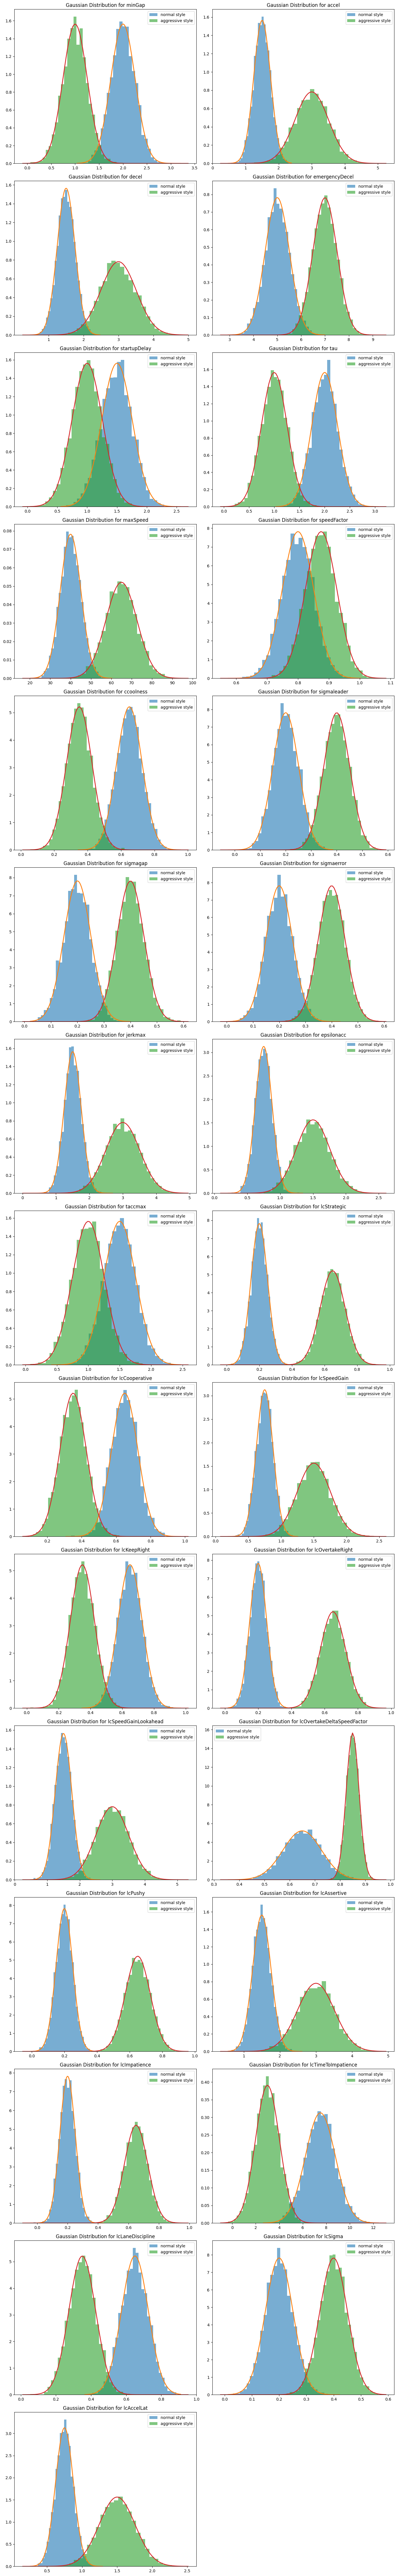

In [184]:
# Plot the distribution of the parameters for verification
importlib.reload(vehParameters)
vehParameters.showGaussianLLM(param_dict, [data['Parameter'][i] for i in range(len(data['Parameter']))], styles) 

Now we create the distributions files vTypesDistribution.xml containing n_vtypes possible parameters for a given driving style. Here we define the car-following model and the lane-chaning model of the vehicles as well

In [135]:
n_vtypes = 5 # Number of vehicles with varied parameters for each style
importlib.reload(vehParameters)
vehdists = vehParameters.generateVehicleTypesLLM(param_dict, styles, n_vtypes) # Generates the vehicle types for the vehicles
vehParameters.parseVehicleDistributionsXML(param_dict, vehdists, styles, FOLDER_NAME, car_follow_model="EIDM", lc_model="SL2015") # Parses the vehicles to the XML format and writes it to vTypesDistribution.xml

'<root>\n<vTypeDistribution id="normal">\n\t<vType id="v_normal0" carFollowModel="EIDM" laneChangeModel="SL2015" minGap="1.99" accel="1.9" decel="2.27" emergencyDecel="5.05" startupDelay="1.55" tau="2.35" maxSpeed="31.72" speedFactor="0.63" ccoolness="0.29" sigmaleader="0.2" sigmagap="0.3" sigmaerror="0.07" jerkmax="2.98" epsilonacc="0.7" taccmax="1.72" lcStrategic="0.73" lcCooperative="0.6" lcSpeedGain="0.89" lcKeepRight="1.8" lcOvertakeRight="0.19" lcSpeedGainLookahead="1.67" lcOvertakeDeltaSpeedFactor="0.24" lcPushy="0.23" lcAssertive="1.57" lcImpatience="0.06" lcTimeToImpatience="13.96" lcLaneDiscipline="1.71" lcSigma="0.07" lcAccelLat="0.51" probability="0.502855024919639">\n\t\t<param key="device.rerouting.probability" value="1.0"/>\n\t\t<param key="device.rerouting.adaptation-steps" value="18"/>\n\t\t<param key="device.rerouting.adaptation-interval" value="10"/>\n\t</vType>\n\t<vType id="v_normal1" carFollowModel="EIDM" laneChangeModel="SL2015" minGap="2.02" accel="1.69" decel="

Extracting the possible ids from the distribution to generate random trips

In [136]:
vtype_data = extract_vTypeDistribution(f"{FOLDER_NAME}/vTypesDistribution.xml")
vtype_data

{'normal': ['v_normal0', 'v_normal1', 'v_normal2', 'v_normal3', 'v_normal4'],
 'aggressive': ['v_aggressive0',
  'v_aggressive1',
  'v_aggressive2',
  'v_aggressive3',
  'v_aggressive4']}

## Creating Routine Trips

Defining the veh_style for each routine driver and creating the XML file for them, this will be written to **finaltrips.rou.xml** and this file can be used directly as a route file for SUMO if there is no need to generate random trips.

In [129]:
# Merging the trips generated by the LLM with the random trips
final_trips_file_name = "finaltrips.rou.xml"
veh_style_per_student = []
for i in range(len(location_time_list)):
    if i % 2:
        # If the index is odd, use the random trip id
        veh_style_per_student.append(np.random.choice(vtype_data['normal'])) # Randomly choose a vehicle type from the normal distribution
    else:
        veh_style_per_student.append(np.random.choice(vtype_data['aggressive'])) # Randomly choose a vehicle type from the normal distribution

steps_per_stop = 10 # Number of steps in an hour
parseTripXML(location_time_list, parkingAreas, departure_times, veh_style_per_student, use_carla_routine=True, veh_ids=routine_ids ,steps_per_stop=steps_per_stop, out_file_name=final_trips_file_name)
add_missing_vtypes(f"{FOLDER_NAME}/{final_trips_file_name}", f"{FOLDER_NAME}/vTypesDistribution.xml", f"{FOLDER_NAME}/finaltrips.rou.xml") # Adds the missing vehicle types to the final trips file

Updated ROUTES_FILE saved as town05/finaltrips.rou.xml


### Creating Random Trips to fill the simulation

Now we generate random vehicles throughout the simulation that will depart at each departure_step. Notice that they will not be running during all the simulation. The result will be written to **randtrips.rou.xml** and this file can be used as a route-file for SUMO directly if only random trips are desired.

In [147]:
# Generates equally distributed random trips for each vehicle class
# The trips will be written to the file "randtrips.rou.xml" and the vehicle ids will be returned 
rand_trips_file_name = "randtrips.rou.xml"
end_time = 2000 # Overwrite the end time to 2000 seconds, the average time of the routines
random_trips_ids = getRandomTrips(NET_PATH, PA_PATH, end_time, vtype_data, departure_step=10, output_file_name=rand_trips_file_name)
add_missing_vtypes(f"{FOLDER_NAME}/{rand_trips_file_name}", f"{FOLDER_NAME}/vTypesDistribution.xml", f"{FOLDER_NAME}/{rand_trips_file_name}") # Adds the missing vehicle types to the random trips file
print(random_trips_ids)

Success.
Success.
Generated 200 vehicles.
Updated ROUTES_FILE saved as town05/randtrips.rou.xml
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], 'aggressive': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140',

### Merging the trips and updating route files

In [138]:
def merge_routes(alternative_routes, random_routes, output_file_name = 'merged.rou.alt.xml'):
    # Merges two route files into one
    
    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'

    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'
    
    with open(alternative_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if test.startswith('<vType'):
                start_read = True
            if start_read:
                if line.startswith('</routes>'):
                    break
                xml += line

    xml += '<!-- END - LLM Generated trips -->\n\n'
    xml += '<!-- BEGIN - Random Trips -->\n\n'

    with open(random_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if not start_read and test.startswith('<vehicle'):
                start_read = True
            if start_read:
                xml += line

    xml += '<!-- END - Random Trips -->\n\n'

    with open(output_file_name, 'w') as f:
        f.write(xml)
    
    return xml    

In [139]:
def make_output_file(output_file_name, final_trips_file_name = None, random_trips_file_name = None, use_alt_routes = True):
    # Creates the output file with the merged routes:
    # if final_trips is not provided, only the random trips will be used
    # if random_trips is not provided, only the final trips will be used
    # if both are provided, they will be merged
    """
    Generates the output file with the merged routes.
    Args:
        output_file_name (str): Name of the output file.
        final_trips_file_name (str): Name of the final trips file.
        random_trips_file_name (str): Name of the random trips file.
        use_alt_routes (bool): If True, use the alternative routes if the path exists. If False, use the original routes.

    Raises:
        ValueError: If both final_trips_file_name and random_trips_file_name are not provided.
    """

    if not final_trips_file_name and not random_trips_file_name:
        raise ValueError("At least one of final_trips_file_name or random_trips_file_name must be provided.")

    output_file_name = f"{FOLDER_NAME}/{output_file_name}"

    if os.path.exists(output_file_name):
        os.remove(output_file_name)
    
    if final_trips_file_name:
        path = f'{FOLDER_NAME}/{final_trips_file_name}'

        if use_alt_routes: # If we don't want to use the alternative routes, we are going to use the original ones
            alt_path = f'{FOLDER_NAME}/{final_trips_file_name.split(".")[0]}.rou.alt.xml'
        else:
            alt_path = None
        
        if random_trips_file_name:
            rand_path = f'{FOLDER_NAME}/{random_trips_file_name}'
            # If there are alternative routes, merge them
            if alt_path and os.path.exists(alt_path):
                merge_routes(alt_path, rand_path, output_file_name)

            # If alternative routes were found not generated, we are going to use the original ones
            else:
                print(f"Not using alternative routes. Using the original ones from {path}.")
                merge_routes(path, rand_path, output_file_name)

        else:
            if alt_path and os.path.exists(alt_path):
                # Add missing vTypes to the route file and save it into the output file
                shutil.copyfile(alt_path, output_file_name)
    
            else:
                print(f"Not using alternative routes. Using the original ones from {path}.")
                shutil.copyfile(path, output_file_name)

    else:
        rand_path = f'{FOLDER_NAME}/{random_trips_file_name}'

Lastly, merging the file with the routines and the file with the random trips into the **merged.rou.alt.xml** file.

In [148]:
output_file_name = "merged.rou.alt.xml"
final_trips_file_name = "finaltrips.rou.xml"
rand_trips_file_name = "randtrips.rou.xml" # 'rand_trips_file_name'
make_output_file(output_file_name, final_trips_file_name = final_trips_file_name, random_trips_file_name = rand_trips_file_name, use_alt_routes=False)

Not using alternative routes. Using the original ones from town05/finaltrips.rou.xml.


Changing the sumocfg file to use the new files created

In [141]:
# Changing sumocfg to use the new route file
add_xml_child(SUMOCFG_PATH, 'input', 'route-files', output_file_name)

if os.path.exists(f'{FOLDER_NAME}/debug.add.xml'):
    add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', 'debug.add.xml', replace=False)

print("All done! The SUMO configuration file has been updated to use the new route file.")
print(f"You can now run the simulation inside the {FOLDER_NAME} folder using `sumo-gui osm.sumocfg` or generate the data using the Simulation Data section.")

Child <route-files> with value 'merged.rou.alt.xml' already exists. Skipping addition.
Child <additional-files> with value 'debug.add.xml' already exists. Skipping addition.
All done! The SUMO configuration file has been updated to use the new route file.
You can now run the simulation inside the town05 folder using `sumo-gui osm.sumocfg` or generate the data using the Simulation Data section.


In [142]:
try:
    print("IDs for the vehicles that were generated with routines:")
    print(routine_ids)
except:
    print("No vehicles were generated with routines.")

try:
    print("IDs for the vehicles that were generated with random trips:")
    print(random_trips_ids)
except:
    print("No vehicles were generated with random trips.")

IDs for the vehicles that were generated with routines:
['veh0', 'veh1', 'veh2']
IDs for the vehicles that were generated with random trips:
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136'

In [143]:
def save_routines_csv(location_time_list, veh_ids, dir_name = 'routines', use_lat_lon = True):
    os.makedirs(f'{FOLDER_NAME}/{dir_name}', exist_ok=True)

    # Save each dictionary in location_time_list as a CSV file
    for idx, location_time in enumerate(location_time_list):
        df = pd.DataFrame.from_dict(location_time, orient='index')
        # Separate the coords tuple into latitude and longitude columns
        if use_lat_lon:
            df[['latitude', 'longitude']] = pd.DataFrame(df['coords'].tolist(), index=df.index)
        else:
            df[['x_pos', 'y_pos']] = pd.DataFrame(df['coords'].tolist(), index=df.index)

        df.drop(columns=['coords'], inplace=True)  # Drop the original coords column
        csv_path = f'{FOLDER_NAME}/routines/{veh_ids[idx]}.csv'
        df.to_csv(csv_path, index_label='Time')
        print(f"Route saved to: {csv_path}")


In [144]:
# Save the routines of each vehicle in a CSV file
try:
    save_routines_csv(location_time_list, routine_ids, dir_name = 'routines', use_lat_lon = False)
except Exception as e:
    print(f"Error saving routines (were they generated?): \n{e}")


Route saved to: town05/routines/veh0.csv
Route saved to: town05/routines/veh1.csv
Route saved to: town05/routines/veh2.csv


## Simulation Data

In [149]:
def get_all_variables(vehIDs, personIDs, routine=None, delta_time=0.05, end_hours=24, useGui=False, convertGeo=True, freeze_traffic_lights=False):
    """
    Function to get all variables from the simulation.
    :param vehIDs: List of vehicle IDs to subscribe to.
    :param personIDs: List of person IDs to subscribe to.
    :param routine: Dictionary with the routine of the vehicles.
    :param useGui: Boolean to use the GUI or not.
    :param convertGeo: Boolean to convert the coordinates from sumo to lat/lon (does not work when using maps from CARLA).
    :param freeze_traffic_lights: If true, traffic lights are green all the time.
    :return: Dictionary with the variables.
    """

    if useGui:
        traci.start(["sumo-gui", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    else:
        traci.start(["sumo", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    v_variables = {}
    p_variables = {}

    if end_hours != 0:
        end_time = f'{end_hours * 60 * (60/delta_time)}' # 24 hours
    else:
        end_time = ''
    
    add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'time', 'step-length', f'{delta_time}', replace=True)
    add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'time', 'end', end_time, replace=True)

    # Get all traffic light IDs
    if freeze_traffic_lights:
        tls_ids = traci.trafficlight.getIDList()

        # Set all traffic lights to constant green
        for tls_id in tls_ids:
            # Get logic info
            logic = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)[0]

            # Create a new green-only phase
            green_state = 'G' * len(logic.phases[0].state)
            green_phase = traci.trafficlight.Phase(duration=9999999, state=green_state)

            # Replace the logic with only this green phase
            new_logic = traci.trafficlight.Logic(
                logic.programID, logic.type, logic.currentPhaseIndex, [green_phase]
            )
            traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, new_logic)
    
    # To understand when a car has changed its destionation, we need to know it parked
    if routine:
        status = {}
        for id in routine.keys():
            status[id] = {}
            status[id]['parked'] = False # True if the vehicle is parked
            status[id]['count'] = 0 # Count of number of times a vehicle has parked
            status[id]['stops'] = list(routine[id]['name']) # List of stops for the vehicle
            status[id]['desc'] = f'<home-{status[id]["stops"][1]}>' # Description of the vehicle's status

    time = 0
    while traci.simulation.getMinExpectedNumber() > 0:

        for veh_id in (set(traci.simulation.getDepartedIDList()) & set(vehIDs)): # Subscribe to vehicles that have just departed
            print(f"Vehicle {veh_id} has departed")
            traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        
        for veh_id in (set(traci.vehicle.getIDList()) & set(vehIDs)): # Checking status of vehicles that are already in the simulation
            if routine:
                is_parked = traci.vehicle.isStoppedParking(veh_id)
                if not status[veh_id]['parked'] and is_parked:  # Vehicle was not parked and now is parked
                    print(f"Vehicle {veh_id} is parked.")
                    status[veh_id]['parked'] = True
                    status[veh_id]['count'] += 1
                    current_location = status[veh_id]["stops"][status[veh_id]["count"]]
                    next_location = status[veh_id]["stops"][status[veh_id]["count"] + 1] if status[veh_id]["count"] + 1 < len(status[veh_id]["stops"]) else None
                    status[veh_id]['desc'] = f'<{current_location}-{current_location}>'

                elif status[veh_id]['parked'] and not is_parked:  # Vehicle was parked and now is not parked
                    status[veh_id]['parked'] = False
                    current_location = status[veh_id]["stops"][status[veh_id]["count"]]
                    next_location = status[veh_id]["stops"][status[veh_id]["count"] + 1] if status[veh_id]["count"] + 1 < len(status[veh_id]["stops"]) else None
                    status[veh_id]['desc'] = f'<{current_location}-{next_location}>'

        for veh_id in (set(traci.simulation.getArrivedIDList()) & set(vehIDs)): # Vehicles that finished their route
            # traci.vehicle.unsubscribe(veh_id)
            print(f"Vehicle {veh_id} has arrived at its destination.")
            if routine:
                status[veh_id]['count'] += 1
                current_location = status[veh_id]["stops"][status[veh_id]["count"]]
                status[veh_id]['desc'] = f'<{current_location}-{current_location}>'

        results = traci.vehicle.getAllSubscriptionResults().copy()

        for veh_id in results.keys():
            # Converting from x, y sumo coordinates to lat, lon
            if convertGeo:
                x, y = results[veh_id][tc.VAR_POSITION]
                lon, lat = traci.simulation.convertGeo(x, y, fromGeo=False)
                results[veh_id]['longitude'] = lon
                results[veh_id]['latitude'] = lat
                
            if routine:
                results[veh_id]['desc'] = status[veh_id]['desc']

        v_variables[time] = results
        
        time += delta_time
        traci.simulationStep()
        
    traci.close()
    return v_variables, p_variables

In [172]:
def save_data(veh_variables, data_folder_name, vehIDs, delta_time, file_names, new_dir = False, type_ids_random = None, verify=True, type_ids_routine=None, use_desc=True, use_lat_lon=True, speed_threshold=6, acc_threshold=6, derivative_threshold=3):

    """
    Saves the data from the simulation in a folder with the given name.
    :param veh_variables: Dictionary with the variables from the simulation.
    :param data_folder_name: Name of the folder where the data will be saved.
    :param vehIDs: List of vehicle IDs to save.
    :param delta_time: Time step of the simulation.
    :param file_names: Dict containing {vehID: filename} for each ID in vehIDs.
    :param new_dir: If True, creates a new directory for the data.
    :param type_ids_random: Dictionary with the vehicle IDs for the random trips.
    :param type_ids_routine: Dictionary with the vehicle IDs for the routine trips.
    :param verify: If True, verifies the data and corrects outliers.
    :param use_desc: If True, adds a description column to the data.
    :param use_lat_lon: If True, saves the data in latitude and longitude coordinates.
    :param speed_threshold: Threshold for the speed derivative to detect outliers.
    :param acc_threshold: Threshold for the acceleration derivative to detect outliers.
    :param derivative_threshold: Time step to calculate the derivative.
    """

    if new_dir:
        if not os.path.exists(f'{FOLDER_NAME}/{data_folder_name}'):
            os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')
        else:
            shutil.rmtree(f'{FOLDER_NAME}/{data_folder_name}')
            os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')

    for timestep, data in veh_variables.items():
        for vehID, vehData in data.items():

            if use_lat_lon:
                columns = 'timestamp,latitude,longitude,speed,speed_x,speed_y,acceleration,acceleration_x,acceleration_y,angle,acc_diff,gyroscope_z'
            else:
                columns = 'timestamp,x_pos,y_pos,speed,speed_x,speed_y,acc,acc_x,acc_y,angle,acc_diff,gyro_z'

            path = f'{FOLDER_NAME}/{data_folder_name}/{file_names[vehID]}.csv'
            nolabel_path = f'{FOLDER_NAME}/{data_folder_name}/{file_names[vehID]}.csv'
            if use_desc:
                if not os.path.exists(path):

                    with open(path, 'w') as f:
                        f.write(f'{columns},desc\n')
            
            if not os.path.exists(nolabel_path):
                with open(nolabel_path, 'w') as f:
                    f.write(f'{columns}\n')
                    
            write_speed = vehData[SPEED]
            write_angle = vehData[ANGLE]
            write_acc = vehData[ACCELERATION]
            write_x = vehData[POSITION][0]
            write_y = vehData[POSITION][1]

            if verify:
                derivative_threshold
                try: 
                    derivative_speed = (veh_variables[timestep][vehID][SPEED] - veh_variables[timestep-derivative_threshold][vehID][SPEED]) / derivative_threshold
                    derivative_acceleration = (veh_variables[timestep][vehID][ACCELERATION] - veh_variables[timestep-derivative_threshold][vehID][ACCELERATION]) / derivative_threshold
                except:
                    derivative_speed = 0
                    derivative_acceleration = 0
                    
                # Making verification to ensure there are no outliers
                if derivative_speed > speed_threshold or derivative_speed < -speed_threshold:
                    last_speed = veh_variables[timestep-delta_time][vehID][SPEED]
                    print(f'Vehicle {vehID} at timestep {timestep} had a speed of {vehData[SPEED]}, it was changed to {last_speed}')
                    veh_variables[timestep][vehID][SPEED] = last_speed
                    write_speed = last_speed

                if derivative_acceleration > acc_threshold or derivative_acceleration < -acc_threshold:
                    last_acc = veh_variables[timestep - delta_time][vehID][ACCELERATION]
                    print(f'Vehicle {vehID} at timestep {timestep} had an acceleration of {vehData[ACCELERATION]}, it was changed to {last_acc}')
                    veh_variables[timestep][vehID][ACCELERATION] = last_acc
                    write_acc = last_acc
                
                if vehData[ANGLE] < 0 or vehData[ANGLE] > 360:
                    last_angle = veh_variables[timestep - delta_time][vehID][ANGLE]
                    print(f'Vehicle {vehID} at timestep {timestep} had an angle of {vehData[ANGLE]}, it was changed to {last_angle}')
                    veh_variables[timestep][vehID][ANGLE] = last_angle
                    write_angle = last_angle

            if write_speed < -100: # Invalid values
                write_speed = 0
                print(f'Vehicle {vehID} at timestep {timestep} had a INVALID speed of {vehData[SPEED]}, it was changed to 0')
            if write_acc < -100 or write_acc > 100: # Invalid values
                write_acc = 0
                print(f'Vehicle {vehID} at timestep {timestep} had a INVALID acceleration of {vehData[ACCELERATION]}, it was changed to 0')

            # Calculating the decomposed acceleration and speed
            write_speed_x = write_speed * np.cos(np.radians(write_angle))
            write_speed_y = write_speed * np.sin(np.radians(write_angle))
            write_acc_x = write_acc * np.cos(np.radians(write_angle))
            write_acc_y = write_acc * np.sin(np.radians(write_angle))
            
            try:
                acc_diff = np.abs((veh_variables[timestep][vehID][ACCELERATION] -
                                veh_variables[timestep - delta_time][vehID][ACCELERATION]) / delta_time)

                current_angle = np.radians(veh_variables[timestep][vehID][ANGLE])
                previous_angle = np.radians(veh_variables[timestep - delta_time][vehID][ANGLE])

                # Proper angle wrapping to handle transitions like 359° -> 0°
                angle_diff = np.arctan2(np.sin(current_angle - previous_angle),
                                        np.cos(current_angle - previous_angle))

                gyroscope_z = angle_diff / delta_time  # radians/second
            except:
                acc_diff = np.abs(write_acc)
                gyroscope_z = 0.0

            if use_lat_lon:
                line = f'{timestep},{vehData["latitude"]},{vehData["longitude"]},{write_speed},{write_speed_x},{write_speed_y},{write_acc},{write_acc_x},{write_acc_y},{write_angle},{acc_diff},{gyroscope_z}'
            else:
                line = f'{timestep},{write_x},{write_y},{write_speed},{write_speed_x},{write_speed_y},{write_acc},{write_acc_x},{write_acc_y},{write_angle},{acc_diff},{gyroscope_z}'

            if use_desc:
                with open(path, 'a') as f:
                    f.write(f'{line},{vehData["desc"]}\n')
            
            with open(nolabel_path, 'a') as f:
                f.write(f'{line}\n')
        
    # Creating the labels file
    if use_desc:
        with open(f'{FOLDER_NAME}/{data_folder_name}/labels.csv', 'w') as f:
            f.write('ID,Type\n')
            found = False
            for i in range(len(vehIDs)):
            
                if type_ids_random and not found:
                    for key, value in type_ids_random.items():
                        if vehIDs[i] in str(value):
                            f.write(f'{vehIDs[i]},{key}\n')
                            found = True
                            break
                    
                if type_ids_routine and not found:
                    for key, value in type_ids_routine.items():
                        if vehIDs[i] in str(value):
                            f.write(f'{vehIDs[i]},{key}\n')
                            break

In [151]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

# Code of each variable to subscribe:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

In [ ]:
output_data_folder = "data_experiment2_sumo"
experiment2_file = 'merged.rou.alt.xml' # The file that contains the routes for the experiment
delta_time = 0.01 # This delta time has to be the same as the one used in CARLA
end_time = 0 # 0 means no end time, the simulation will run until all vehicles finish their route
vehIDs = routine_ids

if os.path.exists(f'{FOLDER_NAME}/{output_data_folder}'):
    shutil.rmtree(f'{FOLDER_NAME}/{output_data_folder}')
os.makedirs(f'{FOLDER_NAME}/{output_data_folder}', exist_ok=True)

add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'input', 'route-files', f'{experiment2_file}', replace=True)
personIDs = []

try:
    veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, delta_time=delta_time, routine=None, end_hours=end_time, useGui=False, convertGeo=False, freeze_traffic_lights=True) # Running the simulation
    
except KeyboardInterrupt as e:
    traci.close() # Close the simulation if there is an error
    print(f"An error occurred: {e}")

Child <route-files> with value 'merged.rou.alt.xml' already exists. Skipping addition.
 Retrying in 1 seconds
Child <step-length> with value '0.01' already exists. Skipping addition.
Child <end> with value '' already exists. Skipping addition.
Vehicle veh0 has departed
Vehicle veh1 has departed
Vehicle veh2 has departed


Step #292.00 (1ms ~= 10.00*RT, ~11000.00UPS, TraCI: 0ms, vehicles TOT 33 ACT 11 BUF 0)    tep #203.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 24 ACT 9 BUF 0)                    ep #248.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 28 ACT 11 BUF 0)                   

Step #486.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 52 ACT 11 BUF 0)                   tep #352.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 39 ACT 12 BUF 0)                   ep #397.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 43 ACT 14 BUF 0)                   p #442.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 48 ACT 13 BUF 0)                   

Step #1045.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 108 ACT 13 BUF 0)                 

Vehicle veh0 has arrived at its destination.
Step #1215.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 125 ACT 8 BUF 0)                  tep #1171.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 121 ACT 11 BUF 0)                 Vehicle veh2 has arrived at its destination.


Step #1316.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 135 ACT 6 BUF 0)                  Vehicle veh1 has arrived at its destination.


Step #1879.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 191 ACT 5 BUF 0)                  

Step #2121.99 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 203 ACT 0 BUF 0)                  tep #1957.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 199 ACT 6 BUF 0)                  ep #2002.00 (1ms ~= 10.00*RT, ~8000.00UPS, TraCI: 1ms, vehicles TOT 203 ACT 8 BUF 0)    p #2047.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 203 ACT 5 BUF 0)                   #2092.00 (1ms ~= 10.00*RT, ~1000.00UPS, TraCI: 1ms, vehicles TOT 203 ACT 1 BUF 0)    
Vehicle veh0 at timestep 151.9200000000068 had a INVALID acceleration of -1389.0, it was changed to 0
Vehicle veh2 at timestep 151.9300000000068 had a INVALID acceleration of -1389.0, it was changed to 0


In [178]:
filesnames = {}
for i in range(len(vehIDs)):
    filesnames[vehIDs[i]] = f'{vehIDs[i]}_{veh_style_per_student[i].split("_")[-1]}'

save_data(veh_variables, output_data_folder, vehIDs, delta_time, file_names=filesnames, new_dir=False, verify=True, use_lat_lon=False, use_desc=False)

Vehicle veh0 at timestep 151.9200000000068 had a INVALID acceleration of -1389.0, it was changed to 0
Vehicle veh2 at timestep 151.9300000000068 had a INVALID acceleration of -1389.0, it was changed to 0


In [ ]:
df = pd.read_csv(f'{FOLDER_NAME}/{output_data_folder}/{filesnames[vehIDs[0]]}.csv')
import matplotlib.pyplot

In [189]:
def plot_df(df):
    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    # Plot acc_x
    axs[0].plot(df['timestamp'], df['acc_x'], label='acc_x')
    axs[0].set_title('Acceleration X over Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('acc_x (m/s²)')
    axs[0].legend()

    # Plot acc_y
    axs[1].plot(df['timestamp'], df['acc_y'], label='acc_y', color='orange')
    axs[1].set_title('Acceleration Y over Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('acc_y (m/s²)')
    axs[1].legend()

    # Plot x_pos vs y_pos
    axs[2].plot(df['x_pos'], df['y_pos'], label='Trajectory', color='green')
    axs[2].set_title('Trajectory: x_pos vs y_pos')
    axs[2].set_xlabel('x_pos')
    axs[2].set_ylabel('y_pos')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

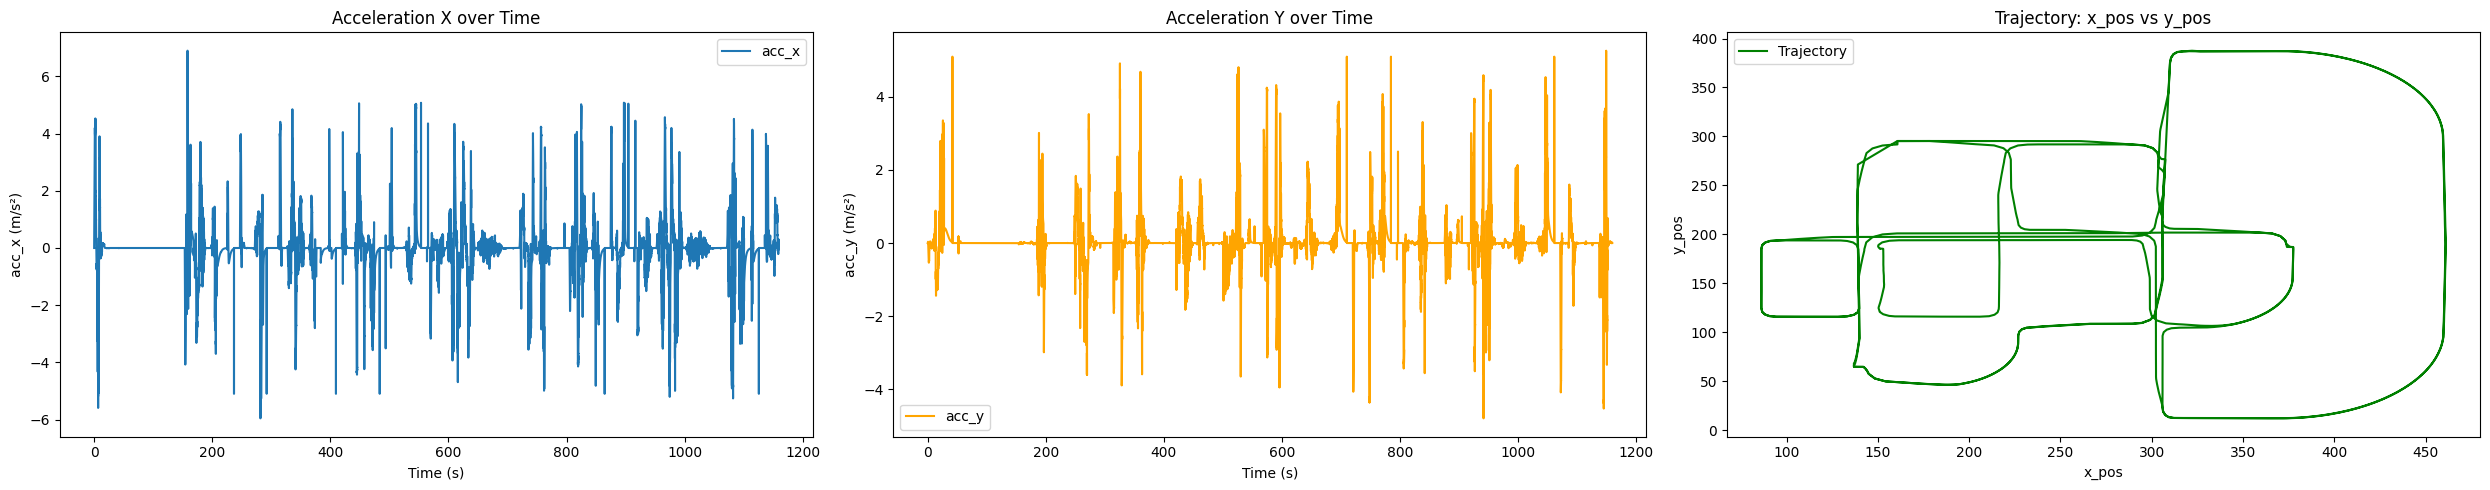

In [190]:
plot_df(df)